<div style="display: flex; justify-content: flex-start; align-items: center;">
    <a href="https://colab.research.google.com/github/msfasha/307304-Data-Mining/blob/main/20251/Module%206-Time%20Series%20Analysis/part1_time_series_fundamentals.ipynb" target="_blank">    
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="height: 25px; margin-right: 20px;">
    </a>
</div>

# Part 1: Fundamentals & Classical Statistical Methods

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Time Series Analysis in Python</h3>
</div>


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Setup and Imports</h3>
</div>

Before we begin, install the required packages:

```bash
pip install pandas numpy matplotlib statsmodels scipy scikit-learn
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">1. What Is a Time Series?</h3>
</div>

A **time series** is a sequence of observations collected **over time**, usually at regular intervals.

Examples:

* Daily stock prices
* Hourly electricity consumption
* Monthly sales revenue
* Sensor measurements every second

Why Time Series Are Different

* Observations are **dependent**
* The order of data points **cannot be shuffled**
* Past values influence future values

This dependency structure is the core challenge of time series analysis.

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Key Components</h3>
</div>

Time series typically contain four components:

1. **Trend (T)**: Long-term increase or decrease in the data
2. **Seasonality (S)**: Regular, predictable patterns that repeat over fixed periods (e.g., yearly, monthly)
3. **Cyclicality (C)**: Patterns that repeat but not at fixed intervals (e.g., economic cycles)
4. **Noise/Irregular (I)**: Random variation that cannot be attributed to trend, seasonality, or cyclicality

### Mathematical Representation

- **Additive Model**: Y(t) = T(t) + S(t) + C(t) + I(t)
  - Use when seasonal variation is roughly constant over time
  
- **Multiplicative Model**: Y(t) = T(t) × S(t) × C(t) × I(t)
  - Use when seasonal variation increases with the level of the series

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Creating a Sample Time Series</h3>
</div>

Let's create a synthetic time series that contains trend, seasonality, and noise:

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate date range
date_range = pd.date_range(start='2020-01-01', end='2023-12-31', freq='D')
n = len(date_range)

# Components
trend = np.linspace(100, 150, n)  # Linear trend from 100 to 150
seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / 365.25)  # Yearly seasonality
noise = np.random.normal(0, 5, n)  # Random noise

# Combine components (additive model)
ts_data = trend + seasonality + noise

# Create pandas Series with datetime index
ts = pd.Series(ts_data, index=date_range, name='Value')

print("Sample Time Series:")
print(ts.head(10))
print(f"\nShape: {ts.shape}")
print(f"Period: {ts.index.min()} to {ts.index.max()}")

Sample Time Series:
2020-01-01    102.483571
2020-01-02     99.514941
2020-01-03    103.650916
2020-01-04    108.233733
2020-01-05     99.653774
2020-01-06     99.859609
2020-01-07    109.131857
2020-01-08    105.278161
2020-01-09     99.298455
2020-01-10    104.563060
Freq: D, Name: Value, dtype: float64

Shape: (1461,)
Period: 2020-01-01 00:00:00 to 2023-12-31 00:00:00


### Visualizing the Time Series

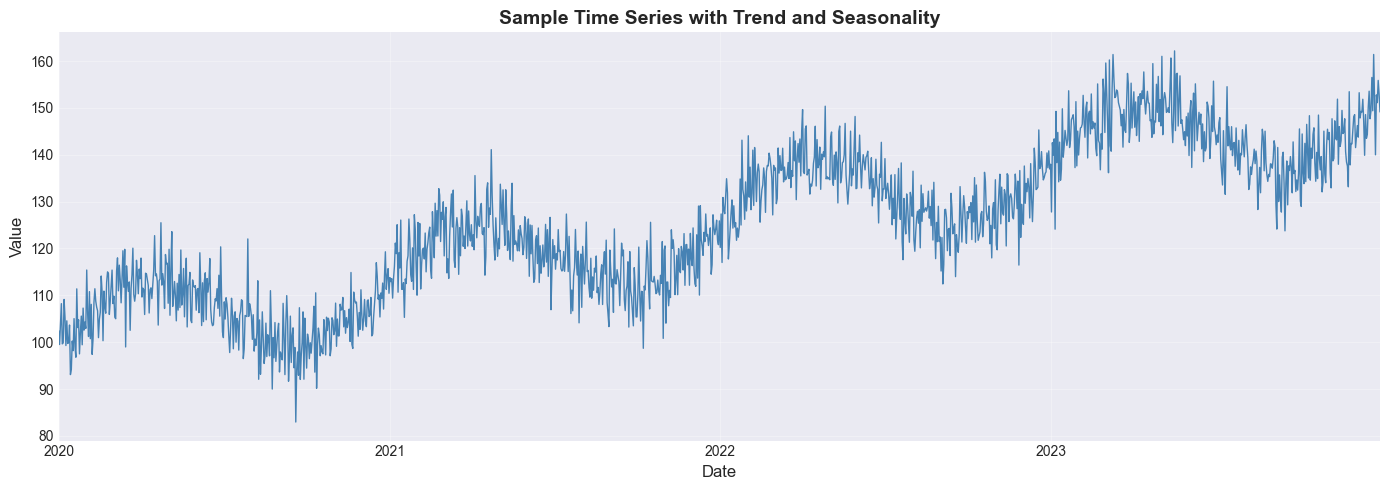

In [4]:
fig, ax = plt.subplots(figsize=(14, 5))
ts.plot(ax=ax, linewidth=1, color='steelblue')
ax.set_title('Sample Time Series with Trend and Seasonality', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">2. Time Series Decomposition</h3>
</div>



<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Theory</h3>
</div>

Decomposition is the process of separating a time series into its constituent components. This helps us:
- Understand the underlying patterns
- Remove seasonality for better modeling
- Identify anomalies
- Choose appropriate forecasting methods

### Classical Decomposition Methods

The most common method is **moving average decomposition**:

1. Estimate trend using moving average
2. Detrend the series
3. Estimate seasonal component by averaging detrended values for each season
4. Calculate residuals: Residual = Original - Trend - Seasonal

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Performing Decomposition</h3>
</div>


In [5]:
# Perform additive decomposition
# Period = 365 because we have daily data with yearly seasonality
decomposition = seasonal_decompose(ts, model='additive', period=365)

# Extract components
trend_component = decomposition.trend
seasonal_component = decomposition.seasonal
residual_component = decomposition.resid

print("Decomposition Components:")
print(f"Trend:    {trend_component.shape}")
print(f"Seasonal: {seasonal_component.shape}")
print(f"Residual: {residual_component.shape}")

Decomposition Components:
Trend:    (1461,)
Seasonal: (1461,)
Residual: (1461,)


### Visualizing Decomposition

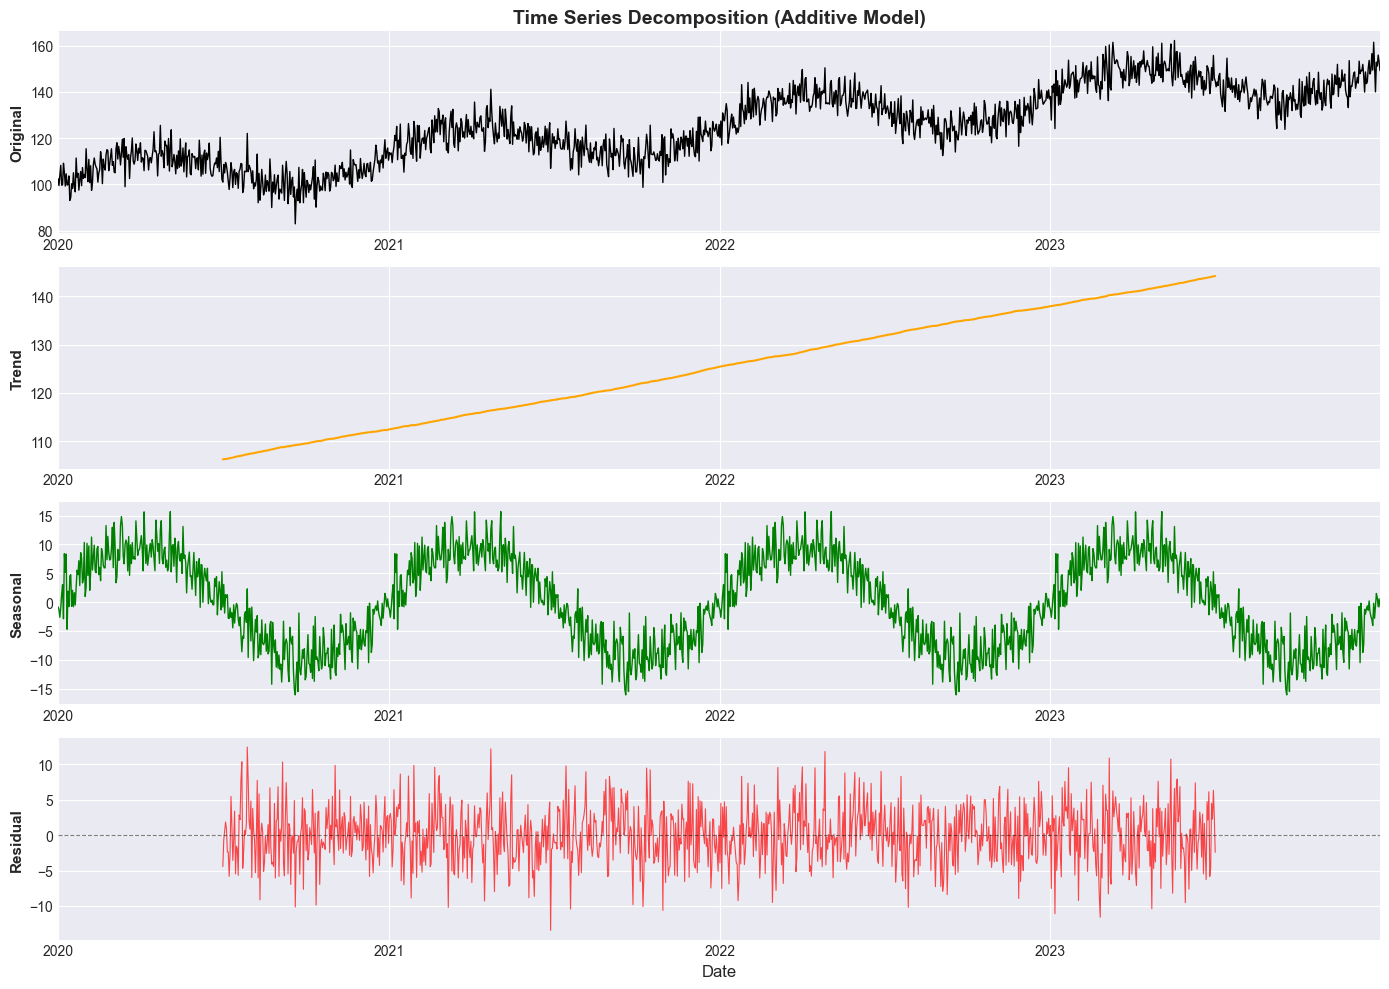

In [6]:
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Original
ts.plot(ax=axes[0], linewidth=1, color='black')
axes[0].set_ylabel('Original', fontsize=11, fontweight='bold')
axes[0].set_title('Time Series Decomposition (Additive Model)', fontsize=14, fontweight='bold')

# Trend
trend_component.plot(ax=axes[1], linewidth=1.5, color='orange')
axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')

# Seasonal
seasonal_component.plot(ax=axes[2], linewidth=1, color='green')
axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')

# Residual
residual_component.plot(ax=axes[3], linewidth=0.8, color='red', alpha=0.7)
axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">3. Stationarity</h3>
</div>


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">What is Stationarity?</h3>
</div>

A time series is **stationary** if its statistical properties (mean, variance, autocorrelation) do not change over time.

### Why Does Stationarity Matter?

Most classical time series models (ARIMA, SARIMA) assume stationarity because:
- Statistical properties are easier to model when constant
- Predictions are more reliable
- Mathematical theory is simpler

### Types of Stationarity

1. **Strict Stationarity**: Joint distribution is time-invariant (very restrictive)
2. **Weak/Covariance Stationarity**: Only mean, variance, and autocorrelation are constant (commonly used)

### Common Non-Stationary Patterns

- **Trend**: Mean changes over time
- **Seasonality**: Pattern repeats at regular intervals
- **Heteroscedasticity**: Variance changes over time

### Augmented Dickey-Fuller (ADF) Test

The ADF test checks the null hypothesis that the series has a unit root (non-stationary).

- **H₀**: Series has a unit root (non-stationary)
- **H₁**: Series is stationary

**Decision Rule**: If p-value < 0.05, reject H₀ (series is stationary)

In [7]:
def check_stationarity(timeseries, name='Series'):
    """
    Perform Augmented Dickey-Fuller test
    """
    print(f"\n{'='*60}")
    print(f"Stationarity Test: {name}")
    print('='*60)
    
    # Remove NaN values
    ts_clean = timeseries.dropna()
    
    # Perform ADF test
    result = adfuller(ts_clean, autolag='AIC')
    
    print(f'ADF Statistic:     {result[0]:.6f}')
    print(f'p-value:           {result[1]:.6f}')
    print(f'# Lags Used:       {result[2]}')
    print(f'# Observations:    {result[3]}')
    print('\nCritical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('\n' + '-'*60)
    if result[1] <= 0.05:
        print(f"✓ STATIONARY (p={result[1]:.4f} < 0.05)")
        print("  → Reject null hypothesis")
    else:
        print(f"✗ NON-STATIONARY (p={result[1]:.4f} > 0.05)")
        print("  → Fail to reject null hypothesis")
    print('-'*60)
    
    return result[1] <= 0.05

### Testing Our Series

In [8]:
# Test original series
is_stationary = check_stationarity(ts, 'Original Time Series')


Stationarity Test: Original Time Series
ADF Statistic:     -0.835398
p-value:           0.808502
# Lags Used:       12
# Observations:    1448

Critical Values:
  1%: -3.435
  5%: -2.864
  10%: -2.568

------------------------------------------------------------
✗ NON-STATIONARY (p=0.8085 > 0.05)
  → Fail to reject null hypothesis
------------------------------------------------------------


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Making a Series Stationary</h3>
</div>

### Method 1: Differencing

Differencing removes trends and can stabilize the mean:

**First Difference**: Y'(t) = Y(t) - Y(t-1)

In [9]:
# Apply first differencing
ts_diff = ts.diff().dropna()

# Test differenced series
is_stationary_diff = check_stationarity(ts_diff, 'First Differenced Series')


Stationarity Test: First Differenced Series
ADF Statistic:     -17.823692
p-value:           0.000000
# Lags Used:       11
# Observations:    1448

Critical Values:
  1%: -3.435
  5%: -2.864
  10%: -2.568

------------------------------------------------------------
✓ STATIONARY (p=0.0000 < 0.05)
  → Reject null hypothesis
------------------------------------------------------------


### Visualizing the Transformation

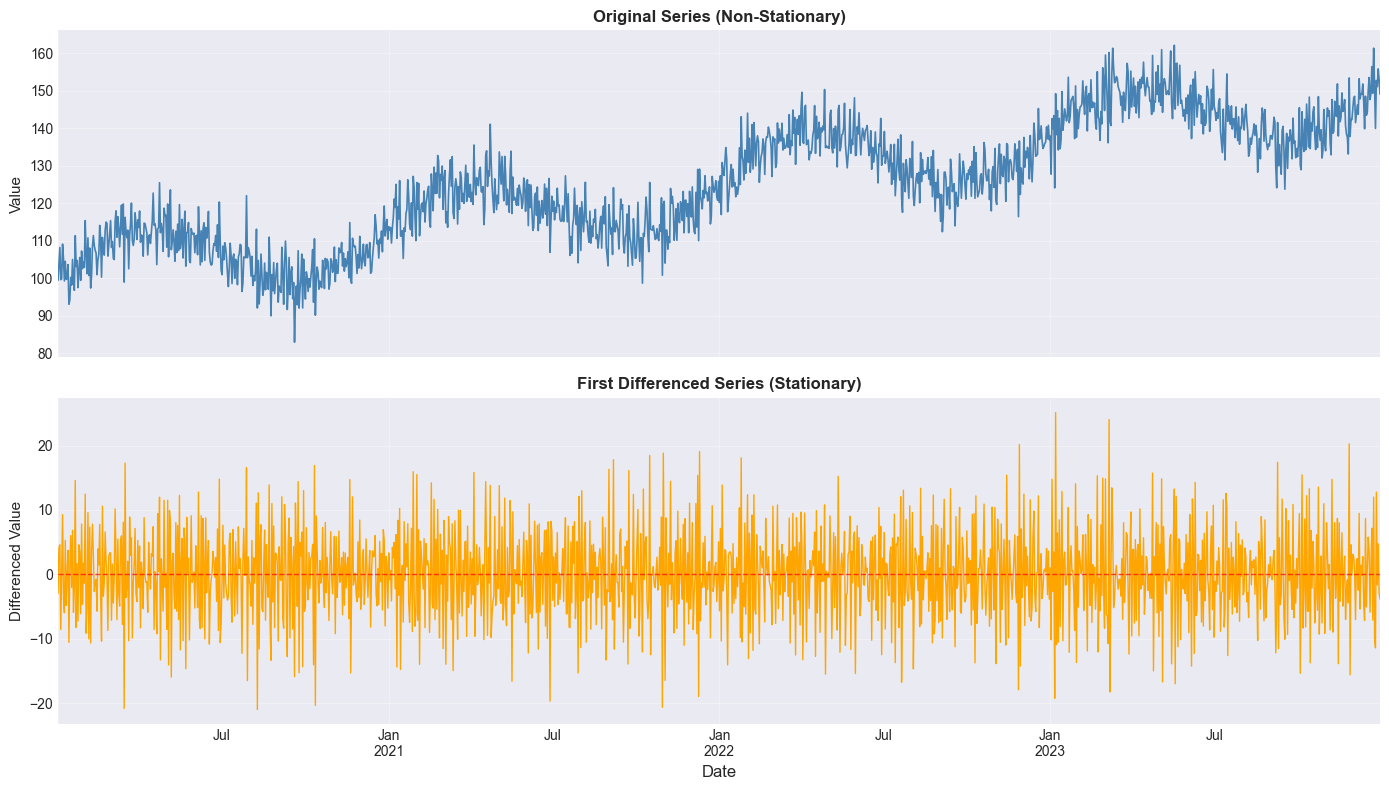

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original
ts.plot(ax=axes[0], linewidth=1.2, color='steelblue')
axes[0].set_title('Original Series (Non-Stationary)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Differenced
ts_diff.plot(ax=axes[1], linewidth=1, color='orange')
axes[1].set_title('First Differenced Series (Stationary)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Differenced Value', fontsize=11)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">4. Autocorrelation Analysis</h3>
</div>

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">ACF: Autocorrelation Function</h3>
</div>

The ACF measures the correlation between observations at different time lags:

**ACF(k) = Corr(Yₜ, Yₜ₋ₖ)**

- Lag 1: correlation between consecutive observations
- Lag 2: correlation between observations 2 time periods apart
- And so on...

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">PACF: Partial Autocorrelation Function</h3>
</div>

The PACF measures the correlation between Yₜ and Yₜ₋ₖ after removing the effect of intermediate lags.

### Why Are ACF and PACF Important?

They help identify the order of AR and MA components:

| Pattern | Model Suggestion |
|---------|------------------|
| PACF cuts off after lag p, ACF decays | AR(p) |
| ACF cuts off after lag q, PACF decays | MA(q) |
| Both decay gradually | ARMA(p,q) |

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Plotting ACF and PACF</h3>
</div>


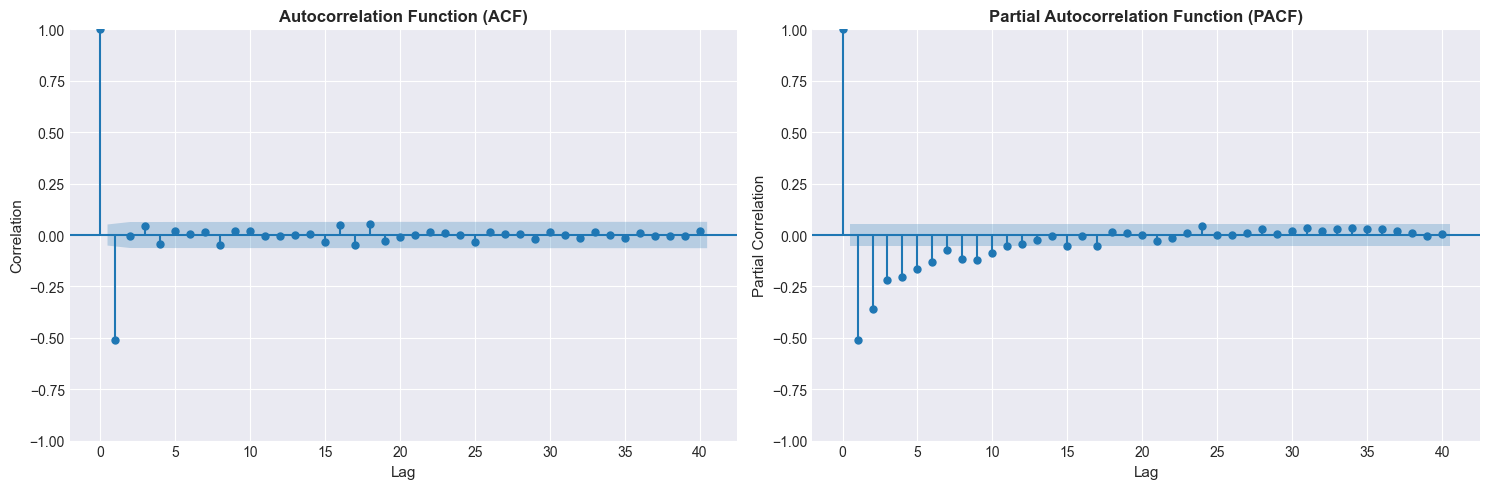

In [11]:
# Use differenced series (should be stationary)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF
plot_acf(ts_diff, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=11)
axes[0].set_ylabel('Correlation', fontsize=11)

# PACF
plot_pacf(ts_diff, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=11)
axes[1].set_ylabel('Partial Correlation', fontsize=11)

plt.tight_layout()
plt.show()

**Interpretation**: 
- Blue shaded area represents the confidence interval
- Bars outside this area are statistically significant
- Look for where bars drop inside the confidence interval (cutoff point)

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">5. Classical Time Series Models</h3>
</div>

| Model | Full Name | Equation | When to Use |
|-------|-----------|----------|-------------|
| AR(p) | Autoregressive | Yₜ = c + φ₁Yₜ₋₁ + ... + φₚYₜ₋ₚ + εₜ | PACF cuts off |
| MA(q) | Moving Average | Yₜ = μ + εₜ + θ₁εₜ₋₁ + ... + θᵩεₜ₋ᵩ | ACF cuts off |
| ARMA(p,q) | AR + MA | Combines both | Both ACF & PACF decay |
| ARIMA(p,d,q) | Integrated ARMA | ARMA on d-times differenced data | Non-stationary series |
| SARIMA(p,d,q)(P,D,Q,s) | Seasonal ARIMA | Adds seasonal components | Seasonal patterns |

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Preparing Data for Modeling</h3>
</div>

Let's create a simpler dataset to demonstrate the models:

In [12]:
# Generate AR(1) process
np.random.seed(123)
n = 300
dates = pd.date_range(start='2022-01-01', periods=n, freq='D')

# AR(1): Y(t) = 0.7 * Y(t-1) + noise
ar_coef = 0.7
ar_data = [0]
for i in range(1, n):
    ar_data.append(ar_coef * ar_data[i-1] + np.random.normal(0, 1))

ts_simple = pd.Series(ar_data, index=dates, name='Value')

# Train-test split (80-20)
train_size = int(len(ts_simple) * 0.8)
train = ts_simple[:train_size]
test = ts_simple[train_size:]

print(f"Train: {len(train)} observations")
print(f"Test:  {len(test)} observations")

Train: 240 observations
Test:  60 observations


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model 1: AR (Autoregressive)</h3>
</div>

### Theory

An AR(p) model predicts the current value using p past values:

**Yₜ = c + φ₁Yₜ₋₁ + φ₂Yₜ₋₂ + ... + φₚYₜ₋ₚ + εₜ**

Where:
- c is a constant
- φ₁, φ₂, ..., φₚ are coefficients
- εₜ is white noise error

### Implementation

In [13]:
# Fit AR(1) model
# ARIMA(p,d,q) with p=1, d=0, q=0
ar_model = ARIMA(train, order=(1, 0, 0))
ar_fit = ar_model.fit()

print("AR(1) Model Summary:")
print(ar_fit.summary())
print(f"\nEstimated coefficient: {ar_fit.params[1]:.4f}")
print(f"True coefficient: {ar_coef}")

AR(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  240
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -345.782
Date:                Tue, 23 Dec 2025   AIC                            697.563
Time:                        17:33:48   BIC                            708.005
Sample:                    01-01-2022   HQIC                           701.771
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0308      0.229     -0.135      0.893      -0.479       0.418
ar.L1          0.7119      0.047     15.074      0.000       0.619       0.805
sigma2         1.0415      0.09

### Interpreting AR(1) Model Output

**What this really is (in one sentence)**

**AR(1) is just linear regression where the predictor is yesterday's value.**

#### Connect it to regular regression (intuition first)

In ordinary regression you write:

> y = β₀ + β₁x₁ + error

In AR(1), you write:

> yₜ = constant + β₁ × yₜ₋₁ + error

Same idea. The "feature" is just the lagged value of y itself.

#### Translate the output into regression language

**1. The coefficients**

```
const     = -0.0308
ar.L1     =  0.7119
sigma2    =  1.0415
```

Think of this as a regression table:

| Feature | Coefficient | What it means |
|---------|-------------|---------------|
| Intercept | -0.031 | Baseline (when yₜ₋₁ = 0) |
| yₜ₋₁ | 0.7119 | Today = 71% of yesterday + noise |
| Error variance | 1.042 | Residual spread |

**The prediction equation is:**

> yₜ = -0.031 + 0.7119 × yₜ₋₁ + εₜ

This is identical to:

> sales_today = -0.031 + 0.7119 × sales_yesterday + noise

**2. Standard errors and p-values**

Exactly the same as regression:

```
              coef    std err    p-value
const        -0.031   0.229      0.893
ar.L1         0.712   0.047      0.000
```

**const**: p = 0.893 (high)
  
  Not significant. Could drop it.

**ar.L1**: p = 0.000 (very low)
  
  Highly significant. Yesterday strongly predicts today.

Same interpretation as:

> feature_1: p = 0.893 → not useful
> feature_2: p = 0.000 → very useful

The model found **strong autocorrelation** in the data.

**3. Model quality metrics**

```
AIC = 697.6
BIC = 708.0
Log Likelihood = -345.8
```

These are **goodness-of-fit measures**, not accuracy metrics.

**AIC and BIC**: Lower is better

Use these to compare models:

- AR(1): AIC = 697.6
- AR(2): AIC = 695.3 → better
- MA(1): AIC = 701.2 → worse

Think of AIC like:

> penalized training error

It balances fit with model complexity.

**Log Likelihood**: Higher is better

Similar to minimizing loss in ML. Maximum likelihood estimation finds coefficients that make the observed data most probable.

**4. Diagnostic tests (are residuals well-behaved?)**

```
Ljung-Box (Q):           0.15    p = 0.70
Jarque-Bera (JB):        0.10    p = 0.95
Heteroskedasticity (H):  0.60    p = 0.03
```

Think of these as **residual plots in test form**.

**Ljung-Box test**

Question: "Do residuals have patterns left?"

- p > 0.05 → No patterns (good)
- p < 0.05 → Patterns remain (bad)

Here: p = 0.70 → residuals look random

This is like checking:

> plot(residuals) shows no trend

**Jarque-Bera test**

Question: "Are residuals normally distributed?"

- p > 0.05 → Yes (good)
- p < 0.05 → No (may need transformation)

Here: p = 0.95 → very normal

This is like checking:

> histogram(residuals) looks bell-shaped

**Heteroskedasticity test**

Question: "Is variance constant over time?"

- p > 0.05 → Yes (good)
- p < 0.05 → No (variance changes)

Here: p = 0.03 → some heteroskedasticity detected

This is like seeing:

> residual spread increases over time

**5. Model validation**

```
Estimated coefficient: 0.7119
True coefficient:      0.7000
```

The model recovered the true data-generating process.

In ML terms:

> The model learned the correct function

This would be like:

- You generate data: y = 2x + noise
- Your model learns: y = 1.98x
- Close match → model works

#### Why it feels alien

**1. No feature matrix visible**

The "feature" (yₜ₋₁) is created internally from the time series.

**2. Maximum likelihood instead of MSE**

Same goal (fit the data), different math. Likelihood is more general than squared error.

**3. Heavy focus on diagnostics**

Econometrics cares deeply about **why** the model works, not just **that** it works.

Statistical inference > predictive accuracy

**4. Different vocabulary**

- ML says: "R² = 0.85"
- Econometrics says: "Log Likelihood = -345, AIC = 697"

Same information, different packaging.

#### How to read this output (decision rules)

**Check coefficients:**

- p < 0.05 → significant → keep
- p > 0.05 → not significant → consider dropping

**Check diagnostics:**

- Ljung-Box p > 0.05 → good (no autocorrelation left)
- Ljung-Box p < 0.05 → bad (model incomplete)

**Compare models:**

- Lower AIC → better model
- Lower BIC → better model (penalizes complexity more)

**Validate:**

- Residuals should look random
- Residuals should be roughly normal
- Variance should be constant (ideally)

#### One grounding sentence you can remember

> AR(1) is linear regression where X is yesterday's y, and the output tells you both fit quality and residual behavior in statistical language instead of ML metrics.

#### Quick interpretation of this specific output

**Model found:** yₜ = 0.71 × yₜ₋₁ + noise

**Constant term:** Not significant (p = 0.89) → probably zero in reality

**Autocorrelation:** Strong (coefficient = 0.71, p < 0.001) → yesterday matters a lot

**Residuals:** Clean (Ljung-Box p = 0.70, JB p = 0.95) → no patterns left

**Minor issue:** Slight heteroskedasticity (p = 0.03) → variance not perfectly constant

**Conclusion:** This is a good model. The AR(1) structure correctly captures the data-generating process.

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model 2: MA (Moving Average)</h3>
</div>

### Theory

An MA(q) model predicts the current value using past forecast errors:

**Yₜ = μ + εₜ + θ₁εₜ₋₁ + θ₂εₜ₋₂ + ... + θᵩεₜ₋ᵩ**

Where:
- μ is the mean
- θ₁, θ₂, ..., θᵩ are coefficients
- εₜ, εₜ₋₁, ... are error terms

### Implementation

In [14]:
# Fit MA(1) model
ma_model = ARIMA(train, order=(0, 0, 1))
ma_fit = ma_model.fit()

print("MA(1) Model Summary:")
print(ma_fit.summary())

MA(1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  240
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -370.431
Date:                Tue, 23 Dec 2025   AIC                            746.863
Time:                        17:33:48   BIC                            757.305
Sample:                    01-01-2022   HQIC                           751.070
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0349      0.120     -0.290      0.771      -0.270       0.200
ma.L1          0.6287      0.051     12.246      0.000       0.528       0.729
sigma2         1.2801      0.11

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model 3: ARMA</h3>
</div>

### Theory

ARMA(p,q) combines AR(p) and MA(q):

**Yₜ = c + φ₁Yₜ₋₁ + ... + φₚYₜ₋ₚ + θ₁εₜ₋₁ + ... + θᵩεₜ₋ᵩ + εₜ**

**Important**: ARMA requires stationary data.

### Implementation

In [15]:
# Fit ARMA(1,1) model
arma_model = ARIMA(train, order=(1, 0, 1))
arma_fit = arma_model.fit()

print("ARMA(1,1) Model Summary:")
print(arma_fit.summary())

ARMA(1,1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  240
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -345.671
Date:                Tue, 23 Dec 2025   AIC                            699.341
Time:                        17:33:49   BIC                            713.264
Sample:                    01-01-2022   HQIC                           704.951
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0308      0.223     -0.138      0.890      -0.468       0.407
ar.L1          0.6912      0.072      9.667      0.000       0.551       0.831
ma.L1          0.0424      

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model 4: ARIMA</h3>
</div>

### Theory

ARIMA(p,d,q) is ARMA applied to d-times differenced data:

- **p**: Order of autoregressive part
- **d**: Degree of differencing
- **q**: Order of moving average part

**Steps**:
1. Difference the series d times to make it stationary
2. Apply ARMA(p,q) to the differenced series

### Implementation

In [16]:
# Fit ARIMA(1,1,1)
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fit = arima_model.fit()

print("ARIMA(1,1,1) Model Summary:")
print(arima_fit.summary())
print(f"\nAIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

# Forecast
forecast_steps = len(test)
arima_forecast = arima_fit.forecast(steps=forecast_steps)

ARIMA(1,1,1) Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  240
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -346.335
Date:                Tue, 23 Dec 2025   AIC                            698.670
Time:                        17:33:49   BIC                            709.100
Sample:                    01-01-2022   HQIC                           702.873
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7190      0.052     13.919      0.000       0.618       0.820
ma.L1         -0.9999      2.479     -0.403      0.687      -5.860       3.860
sigma2         1.0460   

### Visualizing Forecast

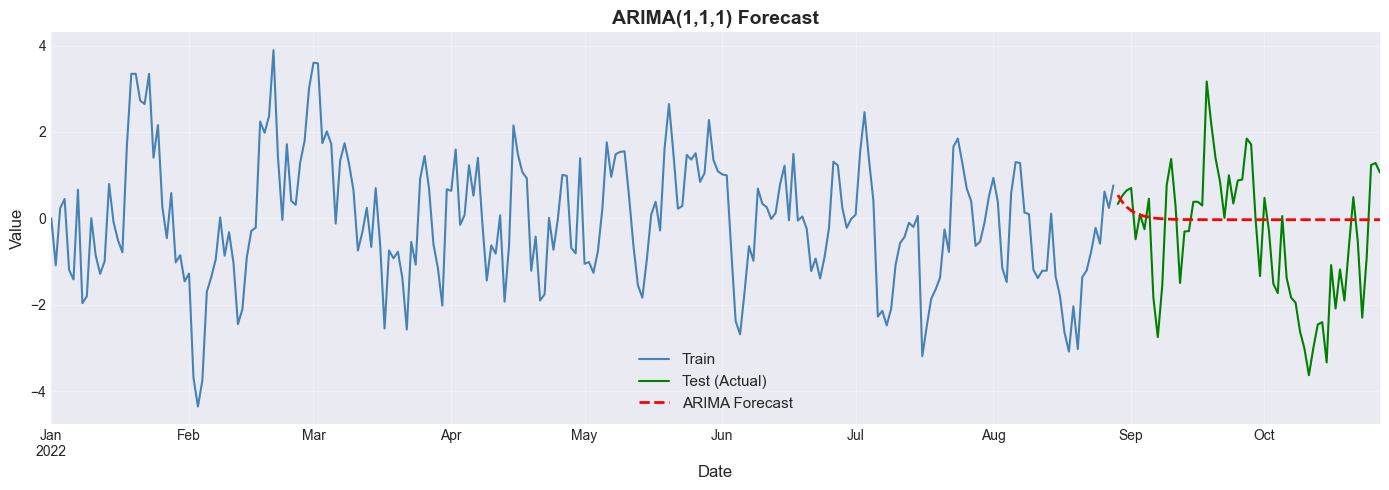

In [17]:
fig, ax = plt.subplots(figsize=(14, 5))

train.plot(ax=ax, label='Train', linewidth=1.5, color='steelblue')
test.plot(ax=ax, label='Test (Actual)', linewidth=1.5, color='green')
arima_forecast.plot(ax=ax, label='ARIMA Forecast', linewidth=2, 
                    linestyle='--', color='red')

ax.set_title('ARIMA(1,1,1) Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model 5: SARIMA (Seasonal ARIMA)</h3>
</div>

### Theory

SARIMA(p,d,q)(P,D,Q,s) extends ARIMA to handle seasonality:

**Non-seasonal part**: (p,d,q)
**Seasonal part**: (P,D,Q,s)
- P: Seasonal AR order
- D: Seasonal differencing order
- Q: Seasonal MA order
- s: Seasonal period (e.g., 12 for monthly data with yearly seasonality)

### Creating Seasonal Data

In [18]:
# Generate monthly data with seasonality
n_months = 240  # 20 years
dates_monthly = pd.date_range(start='2004-01-01', periods=n_months, freq='MS')

# Components
trend = np.linspace(50, 100, n_months)
seasonal = 15 * np.sin(2 * np.pi * np.arange(n_months) / 12)
noise = np.random.normal(0, 3, n_months)

ts_seasonal = pd.Series(trend + seasonal + noise, 
                        index=dates_monthly, 
                        name='Sales')

# Split
train_seas = ts_seasonal[:int(len(ts_seasonal) * 0.8)]
test_seas = ts_seasonal[int(len(ts_seasonal) * 0.8):]

print(f"Seasonal series shape: {ts_seasonal.shape}")
print(f"Train: {len(train_seas)}, Test: {len(test_seas)}")

Seasonal series shape: (240,)
Train: 192, Test: 48


### Fitting SARIMA

In [19]:
# Fit SARIMA(1,1,1)(1,1,1,12)
# Seasonal period = 12 months
sarima_model = SARIMAX(train_seas, 
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

print("SARIMA(1,1,1)(1,1,1,12) Model Summary:")
print(sarima_fit.summary())

# Forecast
sarima_forecast = sarima_fit.forecast(steps=len(test_seas))

SARIMA(1,1,1)(1,1,1,12) Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -463.423
Date:                            Tue, 23 Dec 2025   AIC                            936.845
Time:                                    17:33:49   BIC                            952.782
Sample:                                01-01-2004   HQIC                           943.307
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0128      0.084     -0.151      0.880      -0.178       0.

### Visualizing Seasonal Forecast

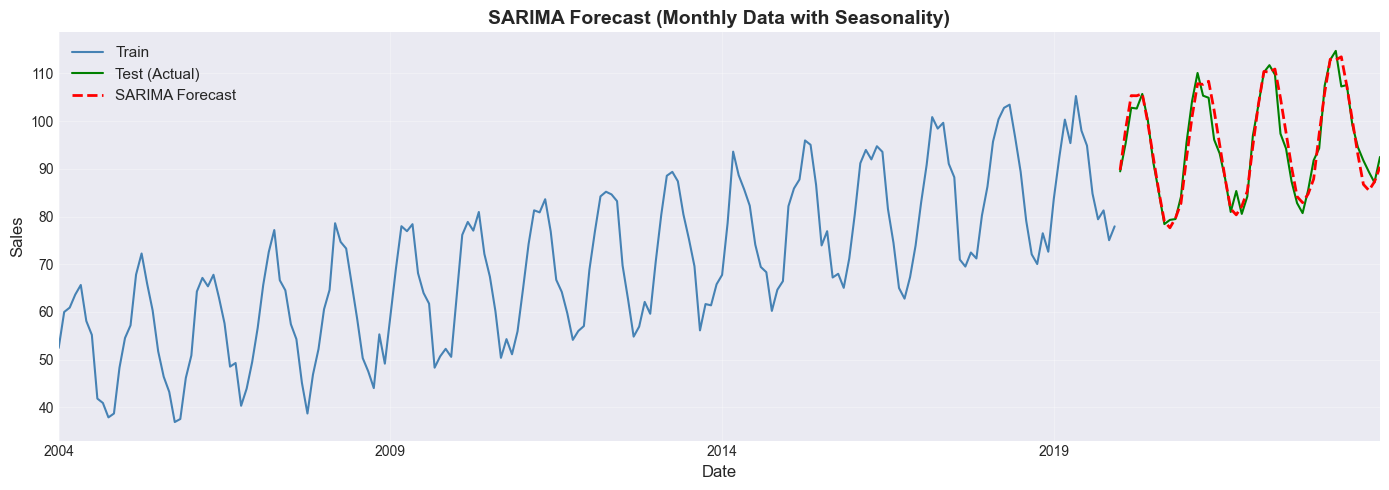

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))

train_seas.plot(ax=ax, label='Train', linewidth=1.5, color='steelblue')
test_seas.plot(ax=ax, label='Test (Actual)', linewidth=1.5, color='green')
sarima_forecast.plot(ax=ax, label='SARIMA Forecast', linewidth=2,
                     linestyle='--', color='red')

ax.set_title('SARIMA Forecast (Monthly Data with Seasonality)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">6. Model Selection</h3>
</div>

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Information Criteria</h3>
</div>

### AIC (Akaike Information Criterion)

**AIC = 2k - 2ln(L)**

Where:
- k = number of parameters
- L = maximum likelihood

### BIC (Bayesian Information Criterion)

**BIC = k·ln(n) - 2ln(L)**

Where:
- n = number of observations

**Rule**: Lower AIC/BIC = better model (balances fit and complexity)

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Grid Search for Best Model</h3>
</div>


In [21]:
def evaluate_arima_models(data, p_range, d_range, q_range):
    """
    Evaluate different ARIMA configurations
    """
    results = []
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted = model.fit()
                    
                    results.append({
                        'order': (p, d, q),
                        'AIC': fitted.aic,
                        'BIC': fitted.bic
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

# Search for best model
print("Searching for best ARIMA model...")
results_df = evaluate_arima_models(
    train,
    p_range=range(0, 3),
    d_range=range(0, 2),
    q_range=range(0, 3)
)

# Sort and display
results_df = results_df.sort_values('AIC')
print("\nTop 5 Models by AIC:")
print(results_df.head())

best_order = results_df.iloc[0]['order']
print(f"\nBest Model: ARIMA{best_order}")

Searching for best ARIMA model...

Top 5 Models by AIC:
        order         AIC         BIC
6   (1, 0, 0)  697.563191  708.005108
13  (2, 0, 1)  698.028252  715.431446
10  (1, 1, 1)  698.670168  709.099558
12  (2, 0, 0)  699.335230  713.257786
7   (1, 0, 1)  699.341125  713.263681

Best Model: ARIMA(1, 0, 0)


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">7. Model Diagnostics</h3>
</div>

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Why Check Diagnostics?</h3>
</div>

After fitting a model, we need to verify that:
1. **Residuals are white noise** (random, no pattern)
2. **Residuals are normally distributed**
3. **No autocorrelation in residuals**
4. **Model assumptions are satisfied**

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Theory: Good Residuals</h3>
</div>

If the model is appropriate, residuals should have:
- Mean ≈ 0
- Constant variance (homoscedastic)
- No autocorrelation
- Normal distribution

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Diagnostic Plots</h3>
</div>


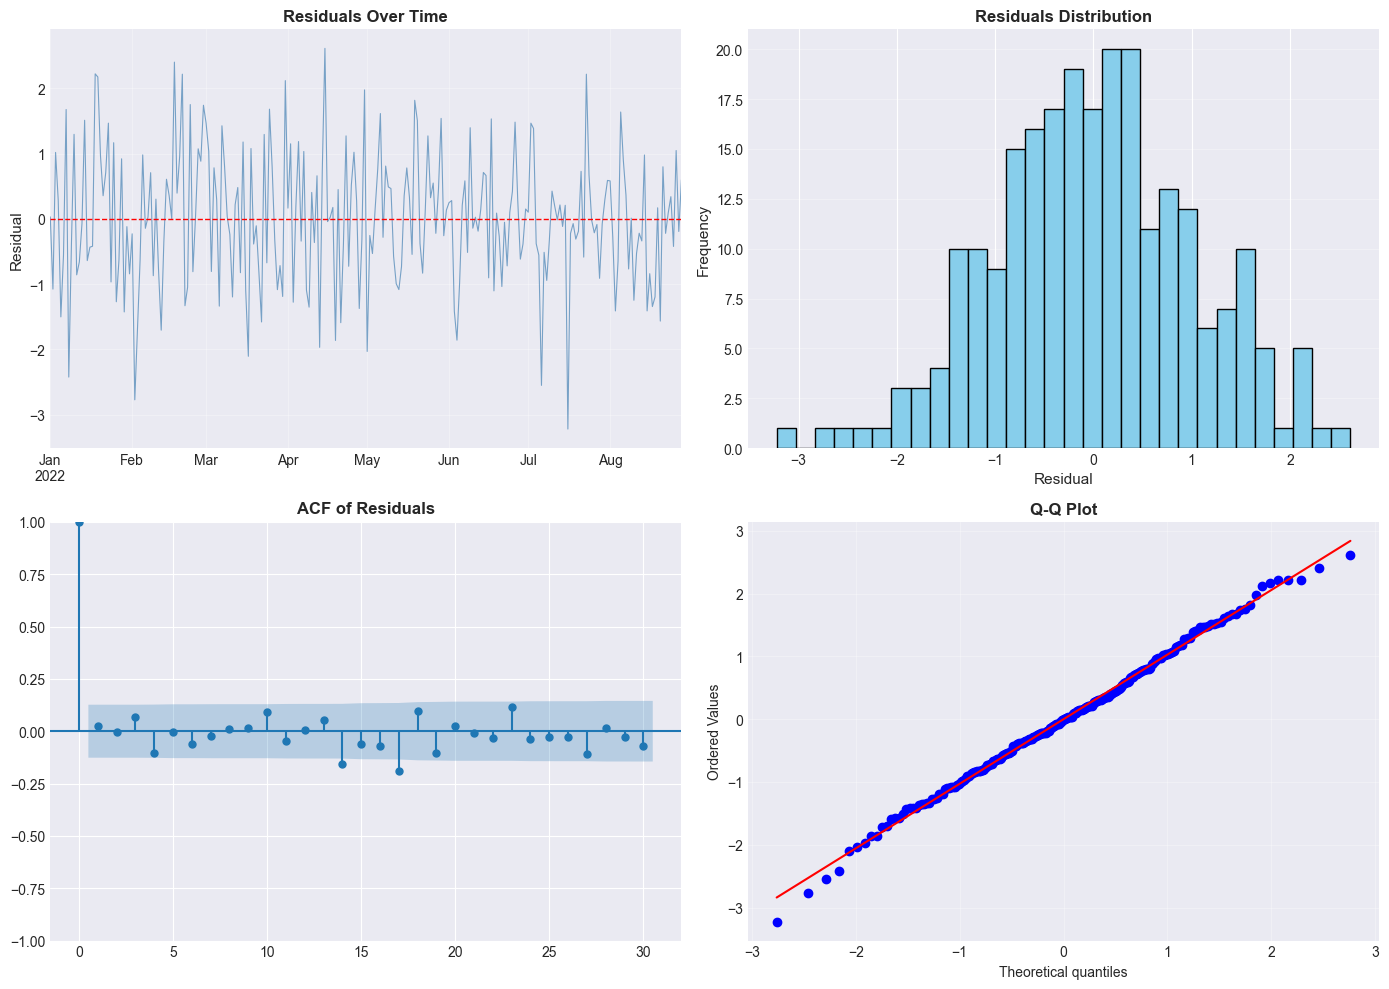

In [22]:
# Get residuals from best model
best_model = ARIMA(train, order=best_order).fit()
residuals = best_model.resid

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
residuals.plot(ax=axes[0, 0], linewidth=0.8, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram
residuals.hist(ax=axes[0, 1], bins=30, edgecolor='black', color='skyblue')
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. ACF of residuals
plot_acf(residuals, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=12, fontweight='bold')

# 4. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Ljung-Box Test</h3>
</div>

Tests the null hypothesis that residuals are independently distributed (no autocorrelation).

- **H₀**: Residuals are white noise (no autocorrelation)
- **H₁**: Residuals have autocorrelation

**Decision**: p-value > 0.05 → residuals are white noise (good!)

In [23]:
# Perform Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)

print("\nLjung-Box Test Results:")
print(lb_test)
print("\nInterpretation:")
print("If p-value > 0.05: Residuals are white noise ✓")
print("If p-value < 0.05: Residuals have autocorrelation ✗")


Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   7.147022   0.711496
20  31.838671   0.045048
30  41.570079   0.077860

Interpretation:
If p-value > 0.05: Residuals are white noise ✓
If p-value < 0.05: Residuals have autocorrelation ✗


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Residual Statistics</h3>
</div>


In [24]:
print("\nResidual Summary Statistics:")
print("="*50)
print(f"Mean:      {residuals.mean():>10.6f}  (should be ≈ 0)")
print(f"Std Dev:   {residuals.std():>10.6f}")
print(f"Min:       {residuals.min():>10.6f}")
print(f"Max:       {residuals.max():>10.6f}")
print(f"Skewness:  {residuals.skew():>10.6f}  (should be ≈ 0)")
print(f"Kurtosis:  {residuals.kurtosis():>10.6f}  (should be ≈ 0)")


Residual Summary Statistics:
Mean:       -0.000090  (should be ≈ 0)
Std Dev:     1.022687
Min:        -3.222888
Max:         2.614799
Skewness:   -0.045184  (should be ≈ 0)
Kurtosis:    0.071627  (should be ≈ 0)


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">8. Model Evaluation</h3>
</div>

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Common Forecasting Metrics</h3>
</div>

### 1. MAE (Mean Absolute Error)
**MAE = (1/n) Σ|yᵢ - ŷᵢ|**

- Average absolute difference
- Same units as original data
- Easy to interpret

### 2. RMSE (Root Mean Squared Error)
**RMSE = √[(1/n) Σ(yᵢ - ŷᵢ)²]**

- Penalizes large errors more
- Same units as original data
- More sensitive to outliers than MAE

### 3. MAPE (Mean Absolute Percentage Error)
**MAPE = (100/n) Σ|((yᵢ - ŷᵢ)/yᵢ)|**

- Expressed as percentage
- Scale-independent
- Undefined when yᵢ = 0

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Computing Metrics</h3>
</div>


In [25]:
def calculate_metrics(actual, predicted):
    """Calculate forecasting metrics"""
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Evaluate forecast
forecast = best_model.forecast(steps=len(test))
metrics = calculate_metrics(test, forecast)

print("\nForecast Evaluation Metrics:")
print("="*50)
print(f"MAE:  {metrics['MAE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAPE: {metrics['MAPE']:.2f}%")


Forecast Evaluation Metrics:
MAE:  1.2387
RMSE: 1.5522
MAPE: 102.35%


<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Summary and Key Takeaways</h3>
</div>

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Workflow for Time Series Modeling</h3>
</div>

1. **Explore Data**
   - Plot the series
   - Identify trend, seasonality, noise
   - Perform decomposition

2. **Check Stationarity**
   - Use ADF test
   - Apply differencing if needed
   - Verify stationarity after transformation

3. **Identify Model Orders**
   - Examine ACF plot → suggests MA order (q)
   - Examine PACF plot → suggests AR order (p)
   - Consider seasonal patterns

4. **Fit Candidate Models**
   - Start with simple models (AR, MA)
   - Try ARIMA for non-stationary data
   - Use SARIMA for seasonal data

5. **Select Best Model**
   - Compare AIC/BIC values
   - Lower is better
   - Balance complexity and fit

6. **Validate Model**
   - Check residual plots
   - Perform Ljung-Box test
   - Ensure residuals are white noise

7. **Forecast and Evaluate**
   - Generate predictions
   - Calculate MAE, RMSE, MAPE
   - Compare with test data

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Model Quick Reference</h3>
</div>

| If you see... | Consider... |
|---------------|-------------|
| Clear trend | Differencing (d > 0) or ARIMA |
| Seasonality | SARIMA with appropriate period |
| PACF cuts off at lag p | AR(p) |
| ACF cuts off at lag q | MA(q) |
| Both decay slowly | ARMA or ARIMA |
| Non-constant variance | Log transformation or multiplicative model |

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Python Libraries</h3>
</div>

- **pandas**: Data manipulation and time series structures
- **statsmodels**: ARIMA, SARIMA, statistical tests, diagnostics
- **matplotlib**: Visualization
- **scipy**: Statistical functions
- **sklearn**: Evaluation metrics

<div style="
    background-color:#8F0177;
    padding:15px;
    border-radius:8px;
    color:white;
    display:flex;
    align-items:center;
">
    <h3 style="margin:0;">Next Steps</h3>
</div>

In **Part 2**, we'll cover:
- Advanced pandas techniques for time series
- Resampling and frequency conversion
- Rolling windows and moving averages
- Time-based indexing and slicing
- Practical data preparation workflows

In **Part 3**, we'll explore:
- Feature engineering for ML models
- Machine learning approaches (XGBoost, Random Forest)
- Deep learning (LSTM, GRU)
- Prophet and modern forecasting tools

*End of Part 1*